In [60]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [61]:
# Fonction qui détecte et match les "orb features" de deux images
def match_image_features(img_path1, img_path2, max_matches=5000):
    
    # On charge les images en niveau de gris
    img1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)
    
    if img1 is None or img2 is None:
        raise FileNotFoundError("Au moins un chemin d'accès est invalide")
    
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Matching des descriptors
    matches = bf.match(des1, des2)

    # On trie les matches par distance 
    matches = sorted(matches, key=lambda x: x.distance)

    # Affichage des meilleurs matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:max_matches], None, flags=2)

    return img_matches, matches



In [62]:
# Fonction qui calcule une distance de similarité entre deux images
def compute_feature_distance(img_path1, img_path2, max_matches=5000):
    _, matches = match_image_features(img_path1, img_path2)

    # On garde seulement les meilleurs matches
    top_matches = matches[:max_matches]

    # Calcul de la distance moyenne
    distances = [m.distance for m in top_matches]
    mean_distance = np.mean(distances)

    return mean_distance, len(top_matches) 



In [63]:
# Fonction qui retrouve à partir d'une image d'une carte qu'on lui donne la carte pixies  
# qui lui correspond
def find_card(image_path, image_index):
    if image_path is None:
        print(f"Pas de carte détectée au  {image_index}-eme emplacement")
        return None
    min_distance = np.inf
    pixies = None
    for file in os.listdir(f"modeles/{image_index}"):
        dist = compute_feature_distance(image_path, f'modeles/{image_index}/{file}')[0]
        if dist < min_distance:
            min_distance = dist
            pixies = file
    matched_img, matches = match_image_features(image_path, f'modeles/{image_index}/{pixies}')
    plt.figure(figsize=(12, 6))
    plt.imshow(matched_img)
    plt.title(f"Top {len(matches)} Feature Matches pour la {image_path} et le modèle")
    plt.axis('off')
    plt.show()
    print(f"La {image_path} correspond à la carte :", pixies)
    return pixies

In [64]:
# On définit une classe des Cartes Pixies afin d'associer au nom des cartes pixies référencées
# les attributs nécessaire au comptage des points
# On définit 3 attributs : 
# score -> correspond à la valeur de la carte en bonus/malus
#       -> si le score dépend des autres cartes de la grille, on lui attribut la valeur spéciale 's'
# season -> correspond à la saison de la carte 
#        -> on donne la valeur 'all' aux cartes multi-saison
# num    -> correspond au numéro de la carte
class PixiesCard():
    def __init__(self, name, index):
        self.num = index
        # Les espaces vides et les cartes retournées sont définies dans cette classe
        # avec les attributs suivants
        if name is None or name == 'back.jpg':
            self.season = None
            self.score = 0
        else:
            self.num = int(name[0])
            if name[1] == 'a':
                self.season = 'all'
                if name[4] == '-':
                    self.score = -float(name[5])
                else:
                    self.score = 0
            else:
                self.season = name[1]
                if name[2] == 's':
                    self.score = 's' # si le bonus dépend des autres cartes
                elif name[2] == '-':
                    self.score = -float(name[3])
                else:
                    self.score = float(name[2])

In [65]:
# Fonction qui compte le nombre d'occurences d'une valeur dans une grille à 2 dimensions
def count_occurences(nested_list, value):
    return sum(item == value for sublist in nested_list for item in sublist)


# Fonction qui renvoie un dictionnaire contenant le nombre d'occurences par saison 
# ainsi qu'une grille 3x3 contenant les saisons
def season_occurences(list_card):
    season_grid = [[list_card[0].season, list_card[1].season, list_card[2].season], 
                   [list_card[3].season, list_card[4].season, list_card[5].season], 
                   [list_card[6].season, list_card[7].season, list_card[8].season]]
    season_occurences = dict()
    season_occurences['all'] = count_occurences(season_grid, 'all')
    for season in ['r', 'v', 'j', 'b']:
        season_occurences[season] = count_occurences(season_grid, season) + season_occurences['all']
    return season_occurences, season_grid

# Fonction qui renvoie Vrai si deux indices sont adjacents dans une grille 3x3, Faux sinon
def is_adj(i, j):
    if i == j+1 or i == j-1 or i == j+3 or i == j-3:
        return True
    return False

# Fonction qui détermine la plus grande zone d'une même saison dans une grille 3x3
# pour une saison donnée
def largest_zone_season(season, season_grid):

    # Création d'une liste des numéros des cartes de la saison donnée
    list_index =  [] 
    for i  in range(3):
        for j in range(3):
            if season_grid[i][j] == season or season_grid[i][j] == 'all':
                list_index.append(1 + i*3 + j)
    if len(list_index) == 0:
        return 0
    if len(list_index) == 1:
        return 1
    
    # Détermination de la plus grande zone contigüe 
    # Il ne peut y avoir au maximum que deux zones de taille 2 ou plus différentes
    zone_1 = set()
    zone_2 = set()
    for i  in list_index:
        for j in list_index:
            if i <= j: 
                continue
            if is_adj(i, j):
                if len(zone_1) == 0:
                    zone_1.add(i)
                    zone_1.add(j)
                elif i in zone_1:
                    zone_1.add(j)
                elif j in zone_1:
                    zone_1.add(i)
                elif i in zone_2:
                    zone_2.add(j)
                elif j in zone_2:
                    zone_2.add(i)
                else:
                    zone_2.add(i)
                    zone_2.add(j)
            else:
                zone_1.add(i)
                zone_2.add(j)
    if zone_1.intersection(zone_2) != set():
        zone_1 = zone_2.union(zone_1)
        zone_2 = set()
    print(f"Zones de la saison {season} détectée :", zone_1, zone_2)
    return max(len(zone_1), len(zone_2))
    
# Fonction qui trouve la plus grande zone contigüe d'une même saison 
# d'une grille 3x3
def find_largest_zone(season_grid):
    largest_zone = 0
    season_max = None
    for season in ['r', 'v', 'j', 'b']:
        zone_size = largest_zone_season(season, season_grid)
        if zone_size > largest_zone:
            largest_zone = zone_size
            season_max = season
    print(f"La plus grande est donc de taille {largest_zone} pour la saison {season_max}")
    return largest_zone, season_max


In [66]:
def cards(contours) :   # Fonction qui définit des cartes à partir des concours détectés 
    cards = []   
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.008*cv2.arcLength(cnt, True), True)
        area = cv2.contourArea(approx)
        if len(approx) >= 4 and area > 5000:  # seuil à ajuster 
#on ne garde que les contours qui définissent une aire suffisamment grande sinon toutes les formes de la carte sont détectées
            cards.append(approx)
    return cards

# calcul des centres des cartes détectées 
def centers(cards):
    centers = []
    for c in range(len(cards)) : 
        x,y = 0,0
        for i in range(len(cards[c])):
            x+=cards[c][i][0][0]
            y+=cards[c][i][0][1]
        centers.append([c, x/len(cards[c]), y/len(cards[c])])
    return centers

# Fonction qui détermine dans quelle case de la grille se trouve le centre de la carte
def cases(centers, cell_w, cell_h) :    
    cases = []
    
    for L in centers :
        c,x,y = L[0],L[1],L[2]
        col = x // cell_w
        row = y // cell_h
        # Sécuriser pour rester dans 0..2
        col = min(col, 2)
        row = min(row, 2)
        if col==0:
            if row==0: 
                case=1
            if row==1:
                case =4
            if row==2:
                case =7
        if col==1:
            if row==0:
                case=2
            if row==1:
                case =5
            if row==2:
                case =8
        if col==2:
            if row==0:
                case=3
            if row==1:
                case =6
            if row==2:
                case =9
        cases.append(case)
    return cases  

# Fonction qui remet les cartes détectées dans le bon ordre en fonction de leur position dans la grille
def ordre(cases_list, cards_hikes) : 
    ordre_list = []
    for i in range(9):
        j = 0
        while j != len(cases_list) and cases_list[j] != i+1 : 
            j+=1
        if j == len(cases_list) : 
            ordre_list.append(None) 
        else : 
            ordre_list.append(cards_hikes[j])
    return ordre_list

#Fonction qui détermine si une carte est validée ou non 
def validate(ordre_list):
    valid = []
    for card in ordre_list : 
        if card is None : 
            valid.append(0)
        elif len(card) > 5: # On considère qu'une carte est validée si le contour compte au moins 6 sommets
            valid.append(1)
        else : 
            valid.append(0)
    return valid

# Fonction principale qui prend en entrée le chemin d'une image et retourne les cartes détectées ainsi que leur validité
def from_image_to_cards(image_path):
    # Charger l'image
    img = cv2.imread(image_path)
    orig = img.copy()
    graybis = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Flouter pour réduire le bruit
    blurredbis = cv2.GaussianBlur(graybis, (5, 5), 0)

    # Détection de bords
    edgesbis = cv2.Canny(blurredbis, 50, 150)

    # Trouver les contours
    contoursbis, _ = cv2.findContours(edgesbis, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    # Filtrer les contours : on garde ceux qui ressemblent à des rectangles
    cardstest = []
    for cnt in contoursbis:
        approx = cv2.approxPolyDP(cnt, 0.02*cv2.arcLength(cnt, True), True)
        area = cv2.contourArea(approx)
        if len(approx) >= 4 and area > 5000:  # seuil à ajuster
            cardstest.append(approx)
        
    # Fusionner tous les points en un seul tableau Nx2
    all_points = np.vstack([c.reshape(-1, 2) for c in cardstest])

    # On va rogner la photo pour enlever les bords où il n'y a pas d'information intéressante
    # Calculer min/max des coordonées 
    x1 = np.min(all_points[:,0])
    x2 = np.max(all_points[:,0])
    y1 = np.min(all_points[:,1])
    y2 = np.max(all_points[:,1])

# On retravaille maintenant sur l'image rognée
    gray = graybis[y1-10:y2+10, x1-10:x2+10]
    carte = img[y1-10:y2+10, x1-10:x2+10]
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cards_hikes = cards(contours) #Détection des sommets

    card_centers = centers(cards_hikes) #Détection des centres des cartes

    h, w, _ = carte.shape
    cell_w = w // 3
    cell_h = h // 3

    cases_list = cases(card_centers, cell_w, cell_h)

    # Dessiner les cartes détectées
    for card in cards_hikes:
        cv2.drawContours(carte, [card], -1, (0, 255, 0), 3)
    


    # Fusionner tous les points en un seul tableau Nx2
    all_points = np.vstack([c.reshape(-1, 2) for c in contours])

    #Remet les cartes dans l'ordre 
    ordre_list = ordre(cases_list, cards_hikes)       


    #Créer la liste des str des noms des cartes
    noms=[]
    #Afficher le résultat : 
    for i, card in enumerate(ordre_list):
        # Extraire la carte
        x, y, w, h = cv2.boundingRect(card)
        cropped = carte[y-10:y+h+10, x-10:x+w+10]
        if cropped is None or cropped.size == 0:
            noms.append(None)
        else:
            cv2.imwrite(f"carte_{i+1}.jpg", cropped)
            cv2.imshow(f"carte_{i+1}", cropped)
            nom=f"carte_{i+1}.jpg"
            noms.append(nom)
    print('Liste des sommets des cartes détectées:',cards_hikes)
    print('Les noms des cartes sont :',noms)
    valid= validate(ordre_list)
    print('Voici les cartes validées : ',valid)
    return noms, valid

In [67]:
# Fonction qui renvoie à partir d'une liste de carte pixies connues,
# ainsi que des données de la validation de chacun des cartes et du numéro de manche
# le score obtenu par un joueur
# list_valid contient 0 si elle est pas validée et 1 si elle est validée
def score_joueur(list_pixies, list_valid, manche):

    # Points de cartes validées
    valid_points = 0
    for i in range(9):
        valid_points += list_valid[i] * (i+1)
    season_occ, season_grid = season_occurences(list_pixies)

    # Calcul  des bonus/malus
    bonus = 0
    for pixies in list_pixies:
        if pixies.score == 's':
            pixies.score = season_occ[pixies.season]
            print(f'Carte {pixies.num} aux bonus spéciaux')
            print(f"Il y a {pixies.score} cartes de la saison {pixies.season}")
        bonus += pixies.score
    
    # On trouve la plus grande zone d'une même saison et on calcule les points
    largest_zone = (manche + 2) * find_largest_zone(season_grid)[0]
    #print('points de zone', largest_zone)
    return largest_zone, bonus, valid_points


# La fonction qui permet de calculer les points par joueur d'une manche
# Elle prend en entrée le numéro de la manche, et un nombre indéterminé de chemin d'accès à des photos 
# correspondant aux cartes posées d'un joueur
def calcul_score_manche(manche, *joueurs):
    for joueur in joueurs: #joueur contient la photo des 9 cartes
        print()
        list_cards_path, list_valid = from_image_to_cards(joueur) #fonction de faustine et illias
        list_pixies = []
        i = 0
        for card_path in list_cards_path:
            i += 1
            pixies_card = find_card(card_path, i)
            list_pixies.append(PixiesCard(pixies_card, i))
        #print(list_pixies, list_valid)
        zone, bonus, valid = score_joueur(list_pixies, list_valid, manche)
        print(f'Le joueur {joueurs.index(joueur) + 1} a obtenu {zone} points de zone, {bonus} points des bonus, et {valid} points de validation')
        print(f'Le joueur {joueurs.index(joueur) + 1} a donc obtenu {bonus+zone+valid} points à la manche {manche}' )


Liste des sommets des cartes détectées: [array([[[534, 650]],

       [[529, 958]],

       [[744, 971]],

       [[739, 663]]], dtype=int32), array([[[303, 639]],

       [[292, 948]],

       [[505, 954]],

       [[506, 647]]], dtype=int32), array([[[231, 632]],

       [[ 23, 643]],

       [[ 10, 939]],

       [[ 37, 952]],

       [[ 46, 976]],

       [[262, 963]],

       [[266, 666]],

       [[239, 654]]], dtype=int32), array([[[530, 353]],

       [[530, 628]],

       [[735, 636]],

       [[727, 359]]], dtype=int32), array([[[281, 327]],

       [[271, 599]],

       [[294, 606]],

       [[307, 632]],

       [[499, 629]],

       [[497, 353]],

       [[466, 327]]], dtype=int32), array([[[231, 314]],

       [[ 35, 322]],

       [[ 27, 588]],

       [[ 53, 620]],

       [[243, 622]],

       [[258, 612]],

       [[265, 348]],

       [[240, 338]]], dtype=int32), array([[[287,  45]],

       [[283, 300]],

       [[473, 303]],

       [[475,  51]]], dtype=int32), ar

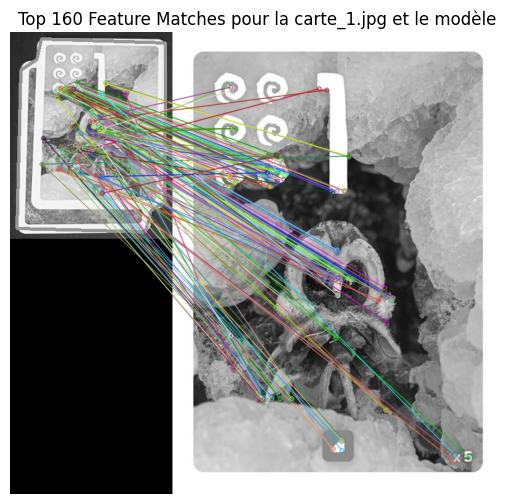

La carte_1.jpg correspond à la carte : 1b6.jpg


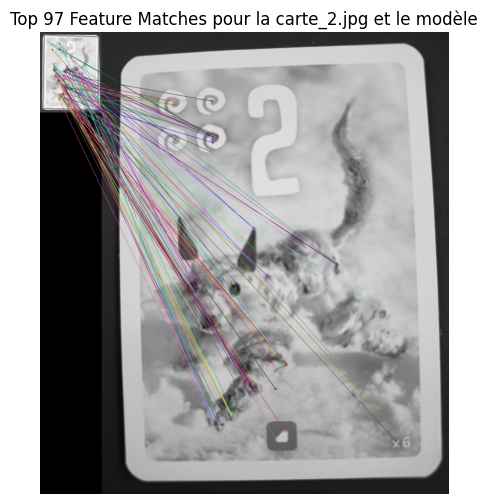

La carte_2.jpg correspond à la carte : 2b4.jpg


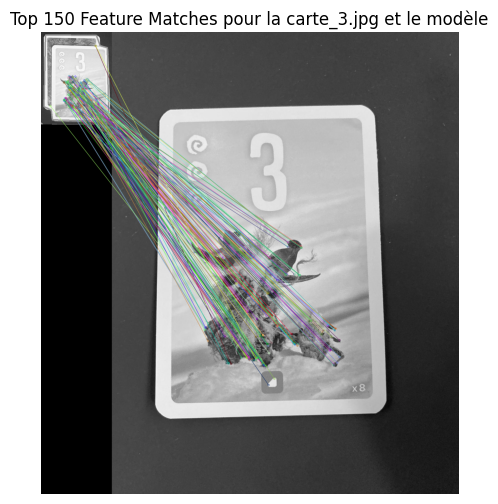

La carte_3.jpg correspond à la carte : 3b3.jpg


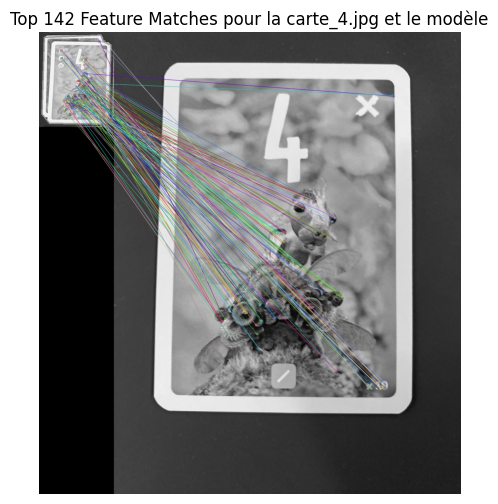

La carte_4.jpg correspond à la carte : 4j-1.jpg


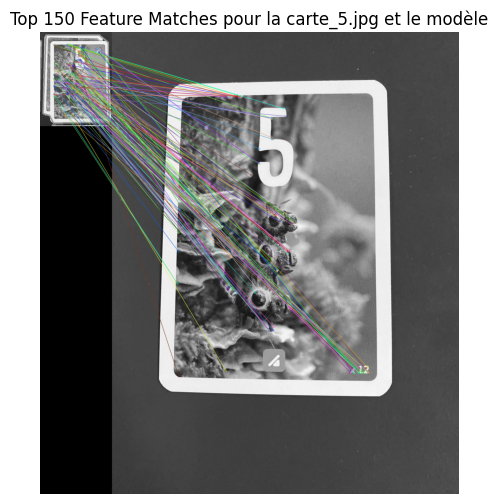

La carte_5.jpg correspond à la carte : 5v0.jpg


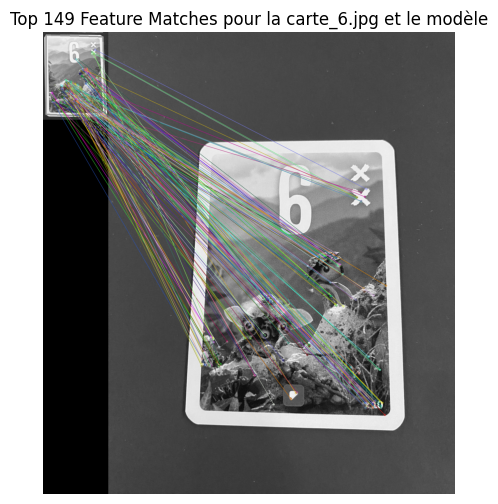

La carte_6.jpg correspond à la carte : 6r-2.jpg


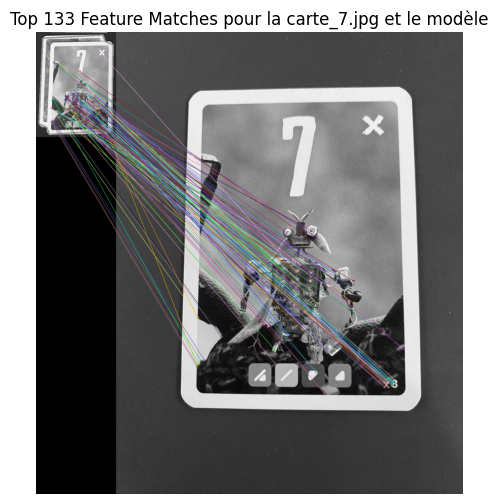

La carte_7.jpg correspond à la carte : 7all-1.jpg


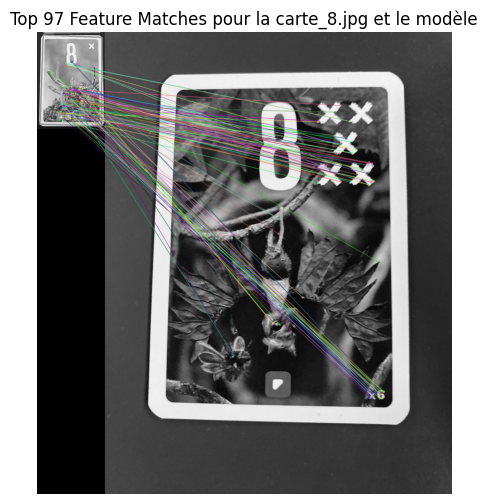

La carte_8.jpg correspond à la carte : 8r-5.jpg


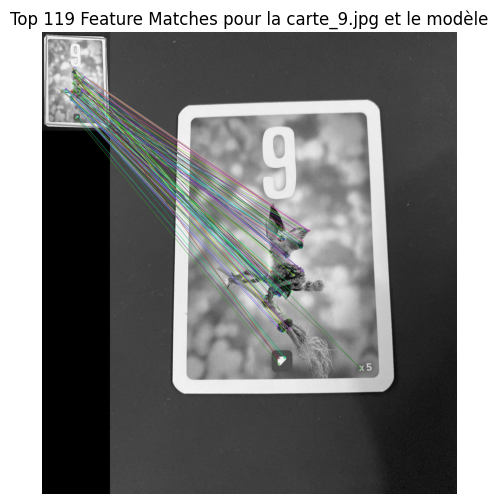

La carte_9.jpg correspond à la carte : 9r0.jpg
Zones de la saison r détectée : {6, 7, 8, 9} set()
Zones de la saison v détectée : {7} {5}
Zones de la saison j détectée : {4, 7} set()
Zones de la saison b détectée : {1, 2, 3, 7} set()
La plus grande est donc de taille 4 pour la saison r
Le joueur 1 a obtenu 12 points de zone, 4.0 points des bonus, et 20 points de validation
Le joueur 1 a donc obtenu 36.0 points à la manche 1


In [68]:
calcul_score_manche(1, 'test_final_2.jpg')